In [21]:
# Install libraries
# !pip install faiss-cpu

In [53]:
# Load libraries 
import os
import faiss
import numpy as np
import pandas as pd 
from time import time
import seaborn as sns
from typing import Union
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [11]:
# Set visualisation style
plt.style.use("ggplot")

In [ ]:
# Load pretrained model 
model = SentenceTransformer("msmarco-MiniLM-L-6-v3")

In [112]:
# Load training dataset - v1
data_train = pd.read_excel("../dataset/v1/enrichment_kbli_prediksi_jenis_training_set.xlsx")
data_test = pd.read_excel("../dataset/v1/enrichment_kbli_prediksi_jenis_testing_set.xlsx")

In [113]:
# Concat dataset and remove duplicate
data_train = pd.concat([data_train, data_test]).drop_duplicates().reset_index()

In [114]:
# Create training dataset into hashmaps
data_train_maps = data_train.to_dict("records")

In [115]:
# Overview dataset
data_train.head()

,index,Jenis Produk,Nama Produk / Rincian,Kode KBLI
0,0,Makanan ringan siap santap,KACANG BAWANG KACANGKU QUALITY PUNCAK,10750
1,1,Produk bakeri,Roti burger Hitam,10710
2,2,Serealia dan produk serealia yang merupakan pr...,Nasi jagung original,10615
3,3,Produk bakeri,Onde-Onde Mekar Merek Aqila Cookies,10710
4,4,"Ikan dan produk perikanan, termasuk moluska, k...",Ikan Pindang Layang,10211


In [116]:
# Check dimension
data_train.shape

(77526, 4)

In [117]:
# Overview missing values
data_train.isna().sum()

index                    0
Jenis Produk             0
Nama Produk / Rincian    0
Kode KBLI                0
dtype: int64

In [118]:
# Overview Sentence Length
sentence_length = data_train['Nama Produk / Rincian'].apply(
    lambda sentence: len(sentence.split())
).tolist()
max_sentence_length = np.round(np.mean(sentence_length) + np.std(sentence_length)).astype("int")

C:\Users\alif\anaconda3\envs\test\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


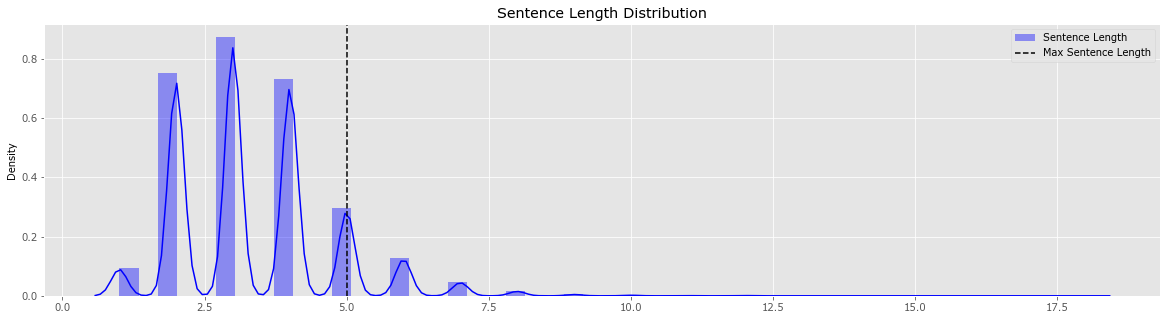

In [119]:
# Visualize density of sentence length distribution
plt.figure(figsize = (20, 5))
sns.distplot(sentence_length, hist = True, kde = True, color = "blue", label = "Sentence Length")
plt.axvline(x = max_sentence_length, color = "k", linestyle = "--", label = "Max Sentence Length")
plt.title("Sentence Length Distribution")
plt.legend()
plt.show()

In [120]:
# Convert Embedding
encoded_sentence = model.encode(data_train['Nama Produk / Rincian'].tolist(), show_progress_bar = True)
encoded_sentence = np.asarray(encoded_sentence.astype("float16"))

Batches:   0%|          | 0/2423 [00:00<?, ?it/s]

In [121]:
# Check dimension
encoded_sentence.shape

(77526, 384)

In [139]:
# Create & Insert Index Faiss
index = faiss.IndexIDMap(faiss.IndexFlatIP(384))
index.add_with_ids(encoded_sentence, np.array(range(0, len(data_train))))
faiss.write_index(index, "corpus/self-declare.index")

In [123]:
# Create function to indexing results
def fetch_product(idx: int, query: str, df: pd.DataFrame = data_train_maps):
    result = {}
    result["query"] = query
    try:
        info = df[idx]
        result["nama_produk_terdekat"]    = info['Nama Produk / Rincian']
        result["prediksi_jenis"] = info["Jenis Produk"]
        result["prediksi_kbli"]  = info["Kode KBLI"]
        result["message"]        = "Prediction Success"
    except IndexError:
        result["nama_produk_terdekat"]    = ""
        result["prediksi_jenis"] = ""
        result["prediksi_kbli"]  = ""
        result["message"]        = "Prediction Failed "
    return result

def search(query: str, index_vector: object = index, model_embedding: object = model, mode: Union["Pred", "Eval"] = "Pred", column_test: str = None):
    query_vector = model_embedding.encode([query])
    selected_idx = index_vector.search(query_vector, k = 1)
    selected_idx = selected_idx[1].tolist()[0][0]
    if mode == "Pred":
        result = [fetch_product(selected_idx, query)]
    if mode == "Eval":
        if column_test is None:
            raise Exception(f"'column_test' should have parameter is using 'Eval' value in parameter 'mode'")
        result = data_train[column_test][selected_idx]
    return result

In [133]:
%%time
# Test result
nama_produk_test = "Kacang 2 Kelinci"
result_prediction = search(nama_produk_test)

print(result_prediction)

[{'query': 'Kacang 2 Kelinci', 'nama_produk_terdekat': 'KACANG KELINCI', 'prediksi_jenis': 'Makanan ringan siap santap', 'prediksi_kbli': 10793, 'message': 'Prediction Success'}]
CPU times: total: 78.1 ms
Wall time: 28.9 ms


In [125]:
# Load libraries 
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [126]:
# Load testing dataset - v1
data_test = pd.read_excel("../dataset/v1/enrichment_kbli_prediksi_jenis_testing_set.xlsx")

In [127]:
# Check dimension
data_test.shape

(15506, 3)

In [128]:
# Overview dataset
data_test.head()

,Jenis Produk,Nama Produk / Rincian,Kode KBLI
0,Produk bakeri,serabi yun,10792
1,Produk bakeri,BOLU LIPAT BIKEZ COOKIES & SNACK,10710
2,Telur olahan dan produk- produk telur hasil ol...,Bihun Telur Ceplok,10799
3,Produk bakeri,Floshroll abon sabrila cake,10710
4,Minuman dengan pengolahan,Es susu coklat,10590


In [129]:
# Apply prediction
predictions_jenis_produk = list(map(lambda x: search(x, mode = "Eval", column_test = "Jenis Produk"), tqdm(data_test['Nama Produk / Rincian'], desc = "Predictions")))
predictions_kbli_produk  = list(map(lambda x: search(x, mode = "Eval", column_test = "Kode KBLI"), tqdm(data_test['Nama Produk / Rincian'], desc = "Predictions")))

Predictions: 100%|███████████████████████████████████████████████████████████████| 15506/15506 [06:06<00:00, 42.35it/s]


In [130]:
# Evaluate Score
print(f"Acc. Jenis Produk: {accuracy_score(data_test['Jenis Produk'].tolist(), predictions_jenis_produk)}")
print(f"Acc. Kode  KBLI  : {accuracy_score(data_test['Kode KBLI'].tolist(), predictions_kbli_produk)}")

Acc. Jenis Produk: 0.9947762156584548
Acc. Kode  KBLI  : 0.9892944666580679


In [137]:
# Save data_train as json
import json
json.dump(data_train_maps, open("corpus/self-declare.json", "w"), indent = 4)